In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# 1. Load dataset
df = pd.read_csv('normalized_dataset.csv')

#2. The Section column is numerically processed
# Use the one-hot coding method
df_encoded = pd.get_dummies(df, columns=['Section'], drop_first=True)

X = df_encoded.drop(['Unnamed: 0', 'FailureMode'], axis=1)
y = df_encoded['FailureMode']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Oversampling the training set with SMOTE (balance class)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# 5. Use PCA
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_smote)
X_test_pca = pca.transform(X_test)

param_grid = {
    'C': [20, 15, 10, 100],         
    'gamma': [1, 0.1, 1.01, 1.5],   
    'kernel': ['rbf']               
}

# 7. Use GridSearchCV with 10 fold cross validation
grid = GridSearchCV(SVC(), param_grid, cv=10, verbose=2, n_jobs=-1)
grid.fit(X_train_pca, y_train_smote)

print("Best parameter configuration:", grid.best_params_)
print("Best model:", grid.best_estimator_)

# 8. Make predictions on the test set and output evaluation metrics
y_pred = grid.predict(X_test_pca)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Fitting 10 folds for each of 16 candidates, totalling 160 fits
Best parameter configuration: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
Best model: SVC(C=100, gamma=1)

Classification Report:
              precision    recall  f1-score   support

           1       0.94      0.92      0.93        37
           2       0.44      0.44      0.44         9
           3       0.89      0.97      0.93        34
           4       1.00      0.67      0.80         6

    accuracy                           0.87        86
   macro avg       0.82      0.75      0.78        86
weighted avg       0.88      0.87      0.87        86

Accuracy: 0.872093023255814
Precision: 0.8201951951951951
Recall: 0.7501545663310369
F1-score: 0.7763821896370613


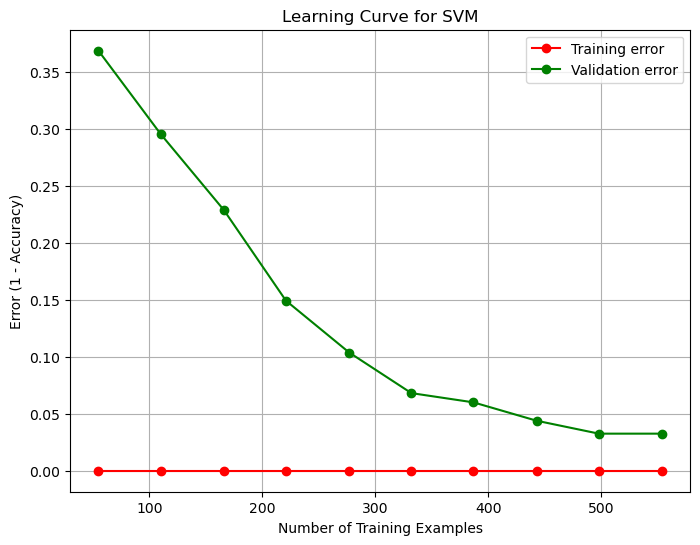

In [2]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
import numpy as np

# Use the best estimator from GridSearchCV for generating the learning curve
best_estimator = grid.best_estimator_

# Compute learning curve scores
train_sizes, train_scores, test_scores = learning_curve(
    best_estimator,
    X_train_pca,
    y_train_smote,
    cv=10,
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=42
)

# Calculate training and validation errors
train_errors = 1 - np.mean(train_scores, axis=1)
validation_errors = 1 - np.mean(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_errors, 'o-', color="r", label="Training error")
plt.plot(train_sizes, validation_errors, 'o-', color="g", label="Validation error")
plt.xlabel("Number of Training Examples")
plt.ylabel("Error (1 - Accuracy)")
plt.title("Learning Curve for SVM")
plt.legend(loc="best")
plt.grid(True)
plt.show()